In [23]:
import pandas as pd
import numpy as np
from bcb import sgs,currency
from fredapi import Fred
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from datetime import date,datetime
from dateutil.relativedelta import relativedelta
from scipy.optimize import curve_fit
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler
import logging
import matplotlib.pyplot as plt

In [33]:
def absolute(serie):
    valor_atual = 1598.41
    yield valor_atual
    for valor in serie[1:]:
        valor = valor / 100
        valor_atual += (valor_atual * valor)
        yield valor_atual
        
def train_test_split(xdata,ydata,horizonte):
    meses = horizonte * 12
    y_train = ydata.iloc[:-meses]
    x_train = xdata.iloc[-meses - len(y_train):-meses]
    return x_train,y_train
        
def get_indicators_selic(start_date):
    dados = {'selic':432,'IPCA_change':433,'pib':1208}
    try:
        dataframe = sgs.get(dados,start = start_date)
    except:
        raise TimeoutError('Erro de conexão com o Banco Central')
    dataframe = dataframe.fillna(method = 'ffill')
    dataframe = dataframe.resample('m').mean()
    dataframe['indice'] = [valor for valor in absolute(dataframe['IPCA_change'].values)]
    del(dataframe['IPCA_change'])
    dataframe = dataframe.dropna()
    return dataframe.iloc[:-2]

# Classe utilizada para criar o modelo LSTM (IPCA)
class LSTM:
    def __init__(self,main_serie,extra_series):
        self.last = main_serie.values[-1]
        self.data = TimeSeries.from_dataframe(main_serie)
        self.extra_data = TimeSeries.from_dataframe(extra_series)
        self.scaler_y = Scaler()
        self.transformed_data = self.scaler_y.fit_transform(self.data)
        self.scaler_x = Scaler()
        self.transformed_extra_data = self.scaler_x.fit_transform(self.extra_data)
    def fit(self,input_size,output_size):
        self.model_cov = BlockRNNModel(
            model = "LSTM",
            input_chunk_length = input_size,
            output_chunk_length = output_size,
            n_epochs = 300,
        )
        self.model_cov.fit(
            series = self.transformed_data,
            past_covariates = self.transformed_extra_data,
            verbose = False,
        )
        return self
    def predict(self,n):
        prediction = self.model_cov.predict(n = n,series = self.transformed_data, past_covariates = self.transformed_extra_data)
        converted_prediction = self.scaler_y.inverse_transform(prediction).values().ravel()
        difference = converted_prediction[0] - self.last
        prediction_final = converted_prediction - difference
        return prediction_final

# Função otilizada para aproximar a curva de câmbio
def simple_square(x,a):
    return (x ** 2) * a

def square(x,a,b,c):
    return ((x ** 2) * a) + (x * b) + c

# Classe utilizada para criar o modelo de regressão + LSTM para o câmbio
class RegressionPlusLSTM:
    def __init__(self,target_data,extra_data,func):
        self.func = func
        self.target_data = target_data
        self.extra_data = extra_data
        self.values = target_data.values.ravel()
        self.x0 = len(target_data)
    
    def fit(self,input_size,output_size):
        # Regressão polinomial no tempo
        self.popt = curve_fit(self.func,list(range(self.x0)),self.values)[0]
        # Sazonalidade
        self.lstm = LSTM(self.target_data,self.extra_data).fit(input_size,output_size)
        return self

    def predict(self,n,peso):
        self.peso = peso
        trend_prediction = np.array([self.func(x,*self.popt) for x in range(self.x0,self.x0 + n)])
        secondary_prediction = self.lstm.predict(n)
        prediction_final = (trend_prediction * self.peso) + (secondary_prediction * (1 - self.peso))
        # Ajustes finais
        last_year_mean = self.values[-12:].mean()
        diferenca = last_year_mean - prediction_final[0]
        # prediction_final = prediction_final + diferenca
        micro_diferenca = self.values[-1] - prediction_final[0]
        prediction_final = np.array([prediction_final[i] + (micro_diferenca * (1 - (i / (len(prediction_final) - 1)))) for i in range(len(prediction_final))])
        return prediction_final

In [34]:
def predict_selic(proportion,test = False,lags = None):
    # Puxando e plotando os dados de IPCA
    df = get_indicators_selic('2000-01-01')
    selic = df[['selic']].copy()
    df = df.drop(['selic'],axis = 1)
    # Treinando o modelo de SELIC
    if not test:
        lags = [5]
    results = {}
    for anos in lags:
        x_train,y_train = train_test_split(df,selic,anos)
        model = RegressionPlusLSTM(y_train,x_train,square).fit(60,12 * anos)
        # Calculando o Erro
        prediction = model.predict(12 * anos,proportion)
        pred_df = selic.copy()
        pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction)
        results[anos] = pred_df
    if test:
        return results
    pred_df['res'] = (pred_df['selic'] - pred_df['prediction']).apply(abs)
    pred = pred_df.dropna()
    res_max = pred['res'].max()
    # Treinando novamente o modelo e calculando o Forecast
    model = RegressionPlusLSTM(selic,df,square).fit(60,12 * anos)
    prediction = model.predict(12 * anos,0.2)
    pred_df = pd.DataFrame({'prediction':prediction},
        index = pd.period_range(start = selic.index[-1] + relativedelta(months = 1),periods = len(prediction),freq = 'M'))
    pred_df['superior'] = [pred + res_max for pred in prediction]
    pred_df['inferior'] = [pred - res_max for pred in prediction]
    std = pd.Series(list(selic.selic.values) + list(pred_df.prediction.values)).rolling(12).std().values[-len(pred_df):]
    pred_df['std'] = std
    return pred_df

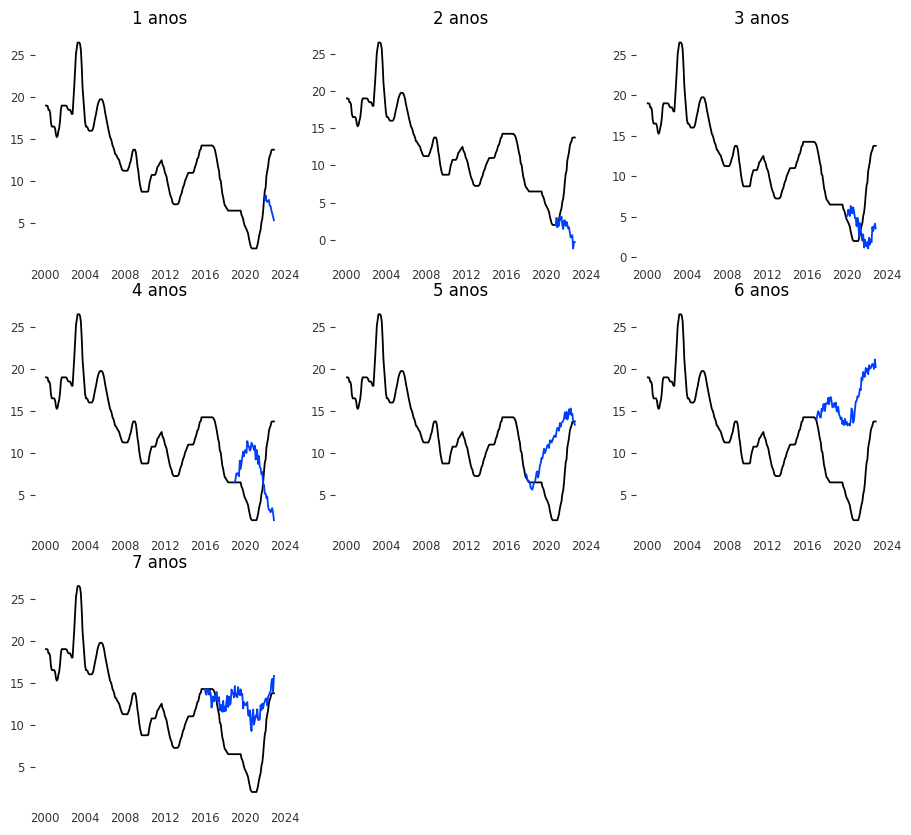

In [26]:
pred_1 = predict_selic(0.2,test = True,lags = [1,2,3,4,5,6,7])
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(10)
for i in range(1,8):
    plt.subplot(3,3,i)
    _ = plt.plot(pred_1[i]['selic'])
    _ = plt.plot(pred_1[i]['prediction'])
    plt.title(f'{i} anos')
    plt.grid(False)
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False

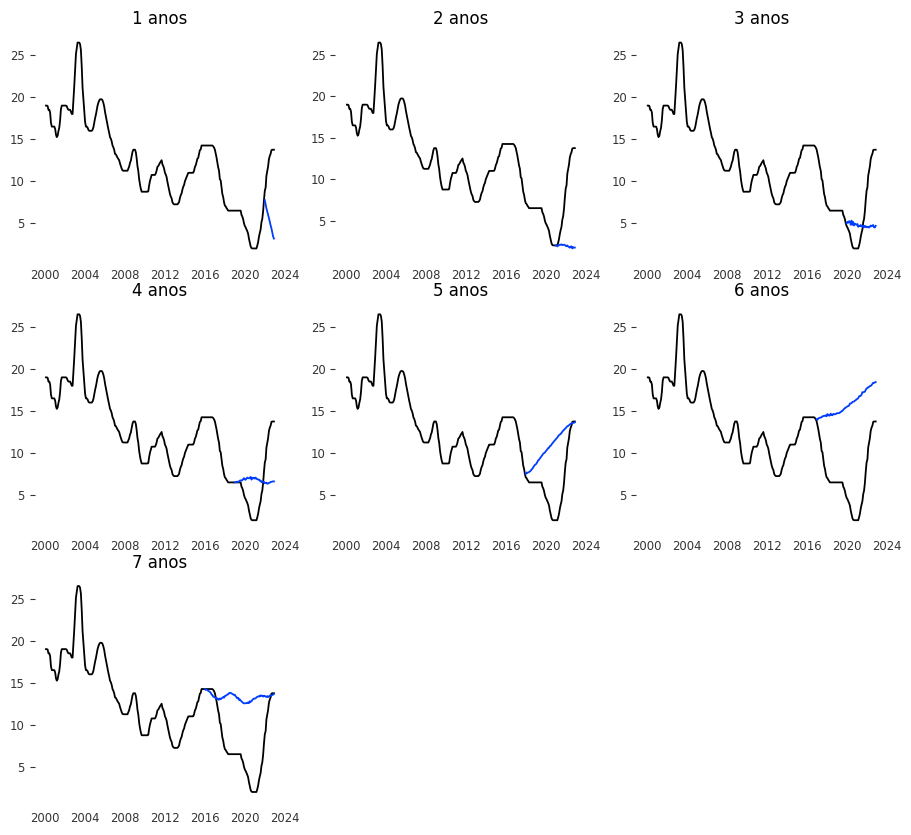

In [29]:
pred_2 = predict_selic(0.9,test = True,lags = [1,2,3,4,5,6,7])
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(10)
for i in range(1,8):
    plt.subplot(3,3,i)
    _ = plt.plot(pred_2[i]['selic'])
    _ = plt.plot(pred_2[i]['prediction'])
    plt.title(f'{i} anos')
    plt.grid(False)
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False

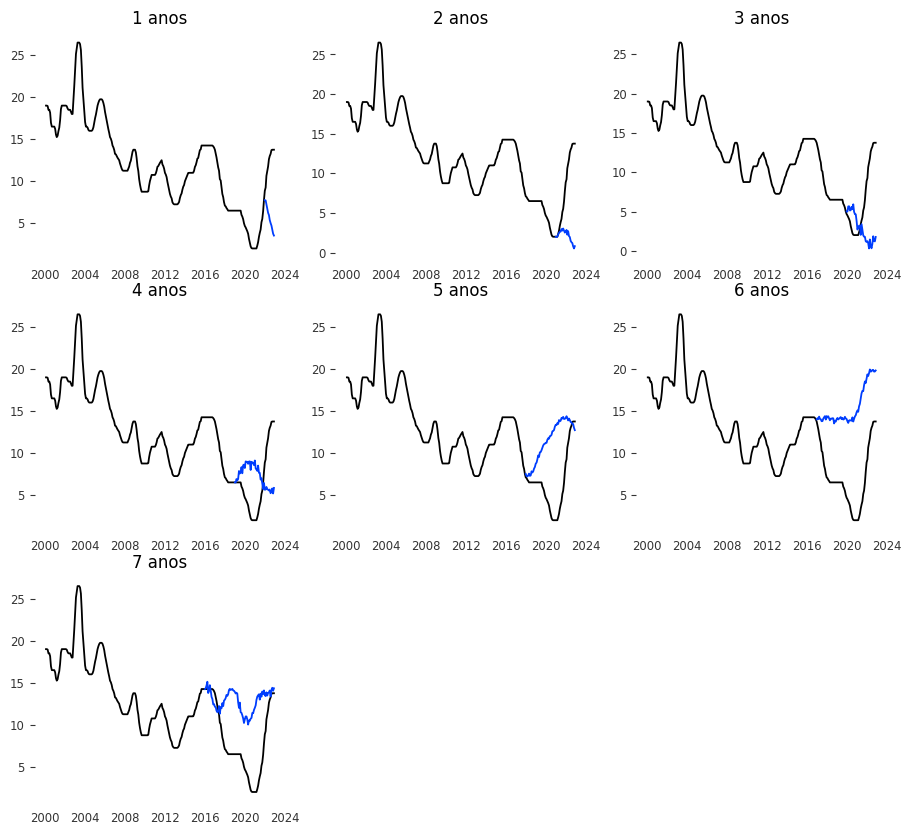

In [30]:
pred_3 = predict_selic(0.6,test = True,lags = [1,2,3,4,5,6,7])
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(10)
for i in range(1,8):
    plt.subplot(3,3,i)
    _ = plt.plot(pred_3[i]['selic'])
    _ = plt.plot(pred_3[i]['prediction'])
    plt.title(f'{i} anos')
    plt.grid(False)
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False

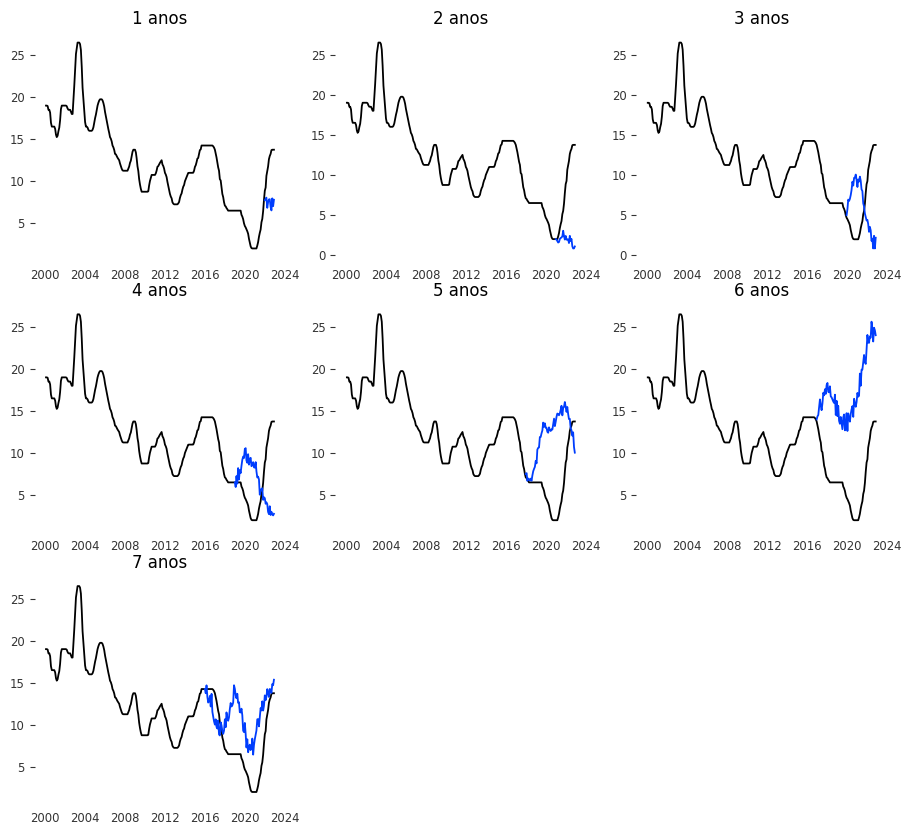

In [36]:
pred_4 = predict_selic(0,test = True,lags = [1,2,3,4,5,6,7])
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(10)
for i in range(1,8):
    plt.subplot(3,3,i)
    _ = plt.plot(pred_4[i]['selic'])
    _ = plt.plot(pred_4[i]['prediction'])
    plt.title(f'{i} anos')
    plt.grid(False)
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False

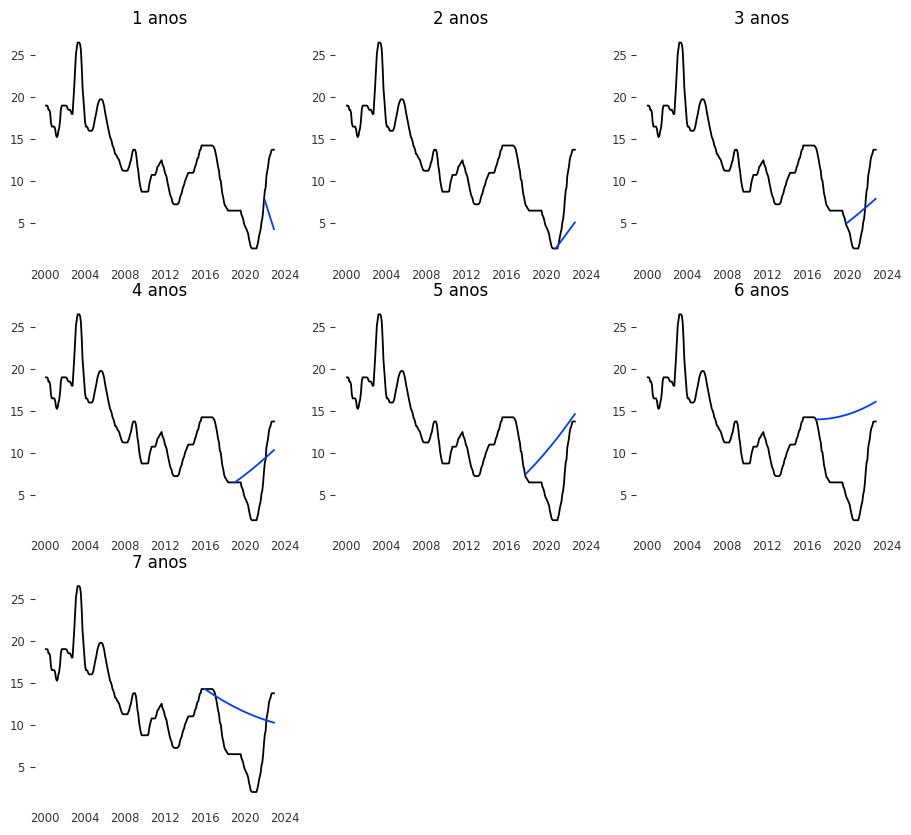

In [37]:
pred_5 = predict_selic(1,test = True,lags = [1,2,3,4,5,6,7])
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(10)
for i in range(1,8):
    plt.subplot(3,3,i)
    _ = plt.plot(pred_5[i]['selic'])
    _ = plt.plot(pred_5[i]['prediction'])
    plt.title(f'{i} anos')
    plt.grid(False)
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False

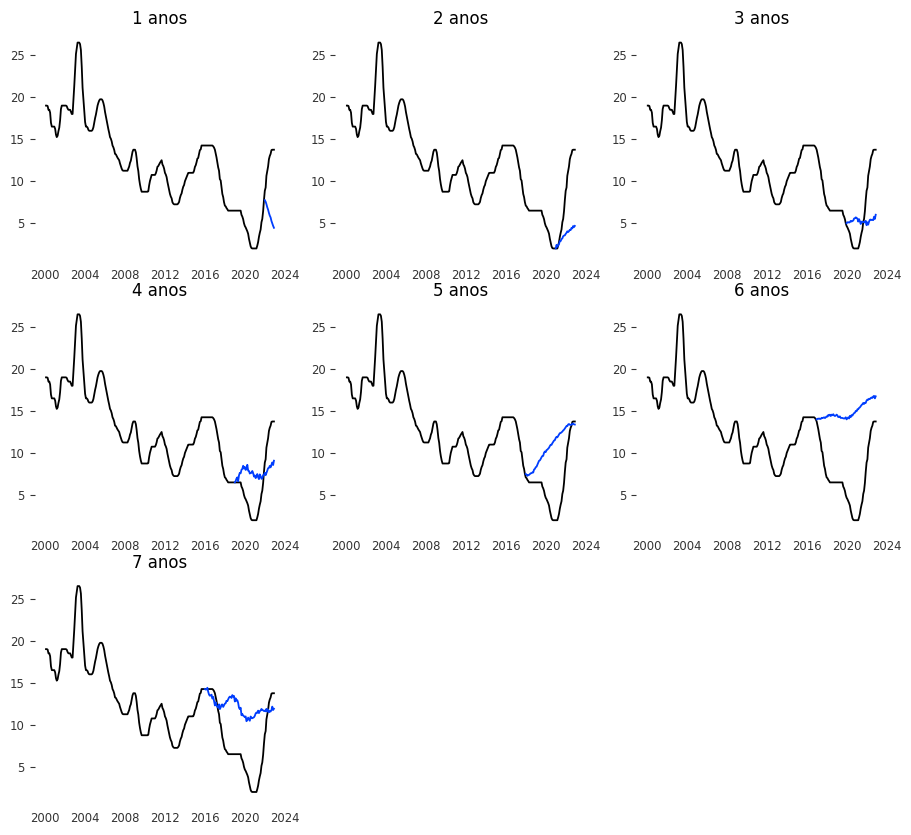

In [38]:
pred_6 = predict_selic(0.8,test = True,lags = [1,2,3,4,5,6,7])
f = plt.figure()
f.set_figwidth(11)
f.set_figheight(10)
for i in range(1,8):
    plt.subplot(3,3,i)
    _ = plt.plot(pred_6[i]['selic'])
    _ = plt.plot(pred_6[i]['prediction'])
    plt.title(f'{i} anos')
    plt.grid(False)
plt.show()